# Benchmarking Julia Code

This notebook is largely inspired by [this excellent blog post](https://opensourc.es/blog/matrix-multiplication-performance/) and illustrates how to benchmark Julia code, as well as a few useful tricks for optimizing it.

In this notebook, we'll examine the performance of the humble matrix multiplication. We'll start with a naive implementation, and gradually optimize it.

In [1]:
# This function performs the update C = C + A*B without allocating memory
function simple_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    for i in 1:m, j in 1:n, k in 1:l
        C[i,j] += A[i,k]*B[k,j]
    end
end

simple_mul! (generic function with 1 method)

In [2]:
n = 256
A = rand(n,n);
B = rand(n,n);
C = rand(n,n);

The Julia standard provides a macro called `@time` to evaluate the running time of an expression (e.g. a function call)

In [3]:
@time simple_mul!(C,A,B)

  0.071747 seconds (39.52 k allocations: 1.966 MiB, 50.87% compilation time)


Note that the above mentions allocations and time spent for compiling the function, so it is not representative of the real performance. If we run the macro again, we see that it takes about 20 ms to compute the product of two 256 times 256 matrices.

In [4]:
@time simple_mul!(C,A,B)

  0.037991 seconds


Using `@time` is fine to get a quick idea of performance, but it only measures the time for one function call. For proper benchmarking, we'll need to bust out the power tools.

Luckily for us, the `BenchmarkTools` package provides just that. It exports several macros, including `@btime` and `@benchmark` which run the expression multiple times to get a better estimate of its performance.

In [5]:
using BenchmarkTools

In [6]:
b_simple = @benchmark simple_mul!(C,A,B)

BenchmarkTools.Trial: 144 samples with 1 evaluation.
 Range (min … max):  32.519 ms … 58.747 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     34.107 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   34.712 ms ±  2.647 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▆██▁█▅▃▁                                                   
  ▇▆████████▇▇▅▇█▄▇▄▆▃▃▁▃▁▁▁▄▁▃▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▃
  32.5 ms         Histogram: frequency by time        45.7 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

Looking at the results above, it seems we're on the order of 10 ms for our simple matmul. Let's compare it with the equivalent from the standard library.

In [7]:
using LinearAlgebra
b_mul = @benchmark mul!(C,A,B)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  160.734 μs … 414.380 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     174.284 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   177.813 μs ±  17.942 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     █ ▇▅ ▅▃                                                     
  ▅▃███████████▇▇▇▆▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▂▂ ▃
  161 μs           Histogram: frequency by time          256 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

That's quite the difference, as the standard library is about 1000 times faster.

There are a couple of simple things we can do to improve on our implementation. First, we can change the order of the loops. Julia stores its arrays in Column Major Order, so we'll get better performance if we access the array elements column by column.

In [8]:
function better_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    for j in 1:n, k in 1:l, i in 1:m
        C[i,j] += A[i,k]*B[k,j]
    end
end

better_mul! (generic function with 1 method)

In [9]:
b_better = @benchmark better_mul!(C,A,B)

BenchmarkTools.Trial: 390 samples with 1 evaluation.
 Range (min … max):  11.692 ms …  18.123 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.693 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.818 ms ± 718.173 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

        ▁  ▁▁▃▆▃▄▃▂█▃▃                                          
  ▄▃▃▆▄▄█▇██████████████▇▆▆▇▇▇▆▆▃▅▄▄▃▃▅▃▃▃▄▄▃▁▄▁▁▃▁▁▁▁▁▁▁▁▁▁▃▃ ▄
  11.7 ms         Histogram: frequency by time         15.2 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

That shaved a bit of performance, but still far from `mul!`. 

The reason reordering the loops improved performance is that modern computer memory is optimized for accessing contiguous areas of memory, so when traversing a Julia matrix by row instead of by column, we are getting what is called "cache misses" where we are jumping between areas of memory that are far apart.

Another simple trick we can use is turning off bounds checking. When accessing a Julia array, the Julia runtime checks that the index we're trying to access is valid (i.e. within the bounds of the array).

If we already know that the index is valid, we can use the macro `@inbounds` to tell the Julia runtime to skip checking it.

Be warned that if your code performs an out of bound indexing with `@inbounds`, this *will* result in a segfault.

In [10]:
function inbounds_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    for j in 1:n, k in 1:l, i in 1:m
        @inbounds C[i,j] += A[i,k]*B[k,j]
    end
end

inbounds_mul! (generic function with 1 method)

In [11]:
b_inbounds = @benchmark inbounds_mul!(C,A,B)

BenchmarkTools.Trial: 2547 samples with 1 evaluation.
 Range (min … max):  1.727 ms …   2.932 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.943 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.958 ms ± 143.761 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

       ▁▁▃▂▄▅▃▃▂▁▇█▆▅▄▃▂                                       
  ▄▅▅▄▆███████████████████▇▆▅▄▄▄▄▃▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂ ▄
  1.73 ms         Histogram: frequency by time        2.52 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

As we can see, just adding a single macro call improved performance by 10. Not bad! But we can still do better.

The next thing to try is using the basic multithreading support from the standard library.

In [12]:
Threads.nthreads()

1

Unfortunately, I can't get Jupyter notebooks to use multiple threads, so we'll have to do that part in the REPL. Just copy the next two cells in a Julia REPL (You'll have to open a REPL with `julia --threads=4` to start julia with multiple threads available).

In [13]:
function threaded_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    Threads.@threads for j in 1:n # NB. We can only apply this to the outer loop
        for k in 1:l, i in 1:m
          @inbounds C[i,j] += A[i,k]*B[k,j]
        end
    end
end

threaded_mul! (generic function with 1 method)

In [14]:
n = 256; A = rand(n,n); B = rand(n,n); C = rand(n,n)
using BenchmarkTools
b_threaded = @benchmark threaded_mul!(C,A,B)

BenchmarkTools.Trial: 2559 samples with 1 evaluation.
 Range (min … max):  1.700 ms …   3.203 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.905 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.947 ms ± 187.170 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▁ ▄▃▆█▇▇▆▄▂▂▁ ██▄                                          
  ▂██████████████▇███▇██▆▅▆▅▄▄▄▅▄▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂ ▄
  1.7 ms          Histogram: frequency by time        2.54 ms <

 Memory estimate: 624 bytes, allocs estimate: 7.

In the above, we get no speedup because this Jupyter Notebook only gets a single thread. When I run it in the REPL with 4 threads, I'm getting a median of 612 µs (slightly faster than `mul!`), but this does incur costs as we need to allocate memory for the `@threads` macro.

Many modern processors can offer special instructions for performing operations on multiple arguments at once (a sort of inprocessor mini-vectorization, if you will). This is known as SIMD (Single Instruction Multiple Data) and can be used to nicely speed up programs.

The Julia compiler already tries to use SIMD instructions when possible, but we can use the `@simd` macro to encourage it to do so.

Be aware that this macro comes with several important caveats, and may disappear in future versions. Use with caution.

In [17]:
function simd_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    for j in 1:n, k in 1:l
        @simd for i in 1:m
            @inbounds C[i,j] += A[i,k] * B[k,j]
        end
    end
end

simd_mul! (generic function with 1 method)

In [18]:
b_simd = @benchmark simd_mul!(C,A,B)

BenchmarkTools.Trial: 2892 samples with 1 evaluation.
 Range (min … max):  1.537 ms …   3.729 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.701 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.724 ms ± 163.908 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▂▃▆██▅▄▂▃▇█▅▁▂                                              
  ███████████████▇▆▄▅▄▃▃▃▃▃▃▃▃▃▃▁▂▂▂▂▁▂▁▁▂▂▂▁▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▂ ▄
  1.54 ms         Histogram: frequency by time        2.62 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

To finish this notebook, we'll use the `LoopVectorization` package, which export a magic macro called `@turbo` which performs a bunch of optimization on a loop, including using SIMD instructions when it can.

In [19]:
using LoopVectorization

In [20]:
function turbo_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    @turbo for j in 1:n # NB. We can only apply this to the outer loop
        for k in 1:l, i in 1:m
            @inbounds C[i,j] += A[i,k]*B[k,j]
        end
    end
end

turbo_mul! (generic function with 1 method)

In [21]:
b_turbo = @benchmark turbo_mul!(C,A,B)

BenchmarkTools.Trial: 9299 samples with 1 evaluation.
 Range (min … max):  472.598 μs … 991.378 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     531.735 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   535.229 μs ±  19.561 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                       ▅     █                                   
  ▂▁▁▁▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▂▁█▅▄▄▄▄█▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  473 μs           Histogram: frequency by time          605 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

And *voila*! We managed to get within spitting distance of `mul!`.
All it took was a single macro call.

(NB. Keep in mind we're only looking at matrices of size 256, and our implementations don't check all the things they should to be correct).

Let's wrap up by comparing all our results on a plot. Aside from printing a pretty histogram, `@benchmark` actually returns the data from all its samples in an object, so we can access them.

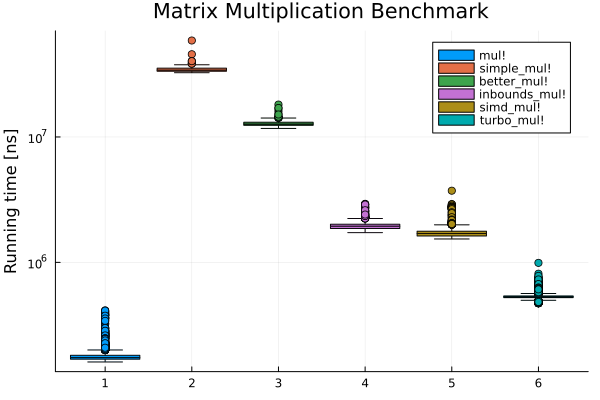

In [22]:
using StatsPlots

boxplot(b_mul.times, label="mul!",
    yscale = :log10,
    ylabel = "Running time [ns]",
    title = "Matrix Multiplication Benchmark"
)
boxplot!(b_simple.times, label="simple_mul!")
boxplot!(b_better.times, label="better_mul!")
boxplot!(b_inbounds.times, label="inbounds_mul!")
#boxplot!(b_threaded.times, label="threaded_mul!")
boxplot!(b_simd.times, label="simd_mul!")
boxplot!(b_turbo.times, label="turbo_mul!")
